In [111]:
import maboss
import ginsim
import pypint
import caspo

import scipy as scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Own functions

In [72]:
from own_functions import *
from MaBoSSTestCase import *


In [ ]:
%load_ext autoreload
%autoreload 2

## Import model

In [130]:
model_name="v7"
model=maboss.load("models/"+model_name+".bnd", "models/"+"charitemodel_v6.cfg")

In [123]:
# write model to SIF (maboss->biolqm->ginsim->sif)
# biolqm_model = maboss.to_biolqm(model)
# ginsim_mutant_simulation = biolqm.to_ginsim(biolqm_model)
# ginsim.service("reggraph").export(ginsim_mutant_simulation, "models/"+model_name+".csv")

In [131]:
# set cell fate+other nodes to 0
nodes_init_off=('Senescence','mitotic_catastrophe','Mitosis','Apoptosis_CC3',
  'CDC25A','CDC25B','CDC25C','CDK1','CDK2','CDK4_6',
   'MK2_HSP27','K_N_HRAS','BRAF','RPS6KA1_CSNK2A1','MEK','ERK1_2','p38',
   'ATR','ATM','TP53','CHEK1','CHEK2','HRR2','FAHRR')
nodes_init_on=('GFR','DSB_SSB')

for nd in nodes_init_off:
    model.network.set_istate(nd,[1,0])
# set input nodes to 1
for nd in nodes_init_on:
    model.network.set_istate(nd,[0,1])

# show logical rules
# model.get_logical_rules()

In [133]:
# model.get_logical_rules()

In [126]:
# run simul
output_nodes=['Apoptosis_CC3','Senescence','mitotic_catastrophe','Mitosis','mitotic_catastrophe',
    'HRR2','DSB_SSB','MK2_HSP27','TP53','ATM','ATR','CHEK1','CHEK2','p38','ERK1_2','BRAF','K_N_HRAS',
    'CDC25A','CDC25B','CDC25C','CDK1','CDK2','CDK4_6','GFR']
maboss.set_output(model,output_nodes)
model.update_parameters(discrete_time=0, use_physrandgen=0,
                            seed_pseudorandom=100, sample_count=500,
                            max_time=40, time_tick=0.1, thread_count=4,
                            statdist_traj_count=100, statdist_cluster_threshold=0.9)
master_results = model.run()

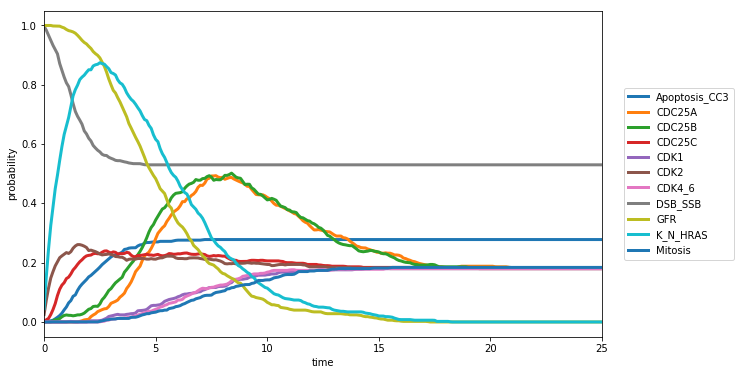

In [127]:
# plot node dynamics
# nodes_probtraj_df=pd.DataFrame(master_results.get_nodes_probtraj())
fig_pars=[3,10,6,"time","probability",25]; nodes_string=['CDK','CDC25','Mitosis','Apopt','RAS','GFR','DSB']
plot_node_dynamics(master_results,nodes_string,fig_pars)

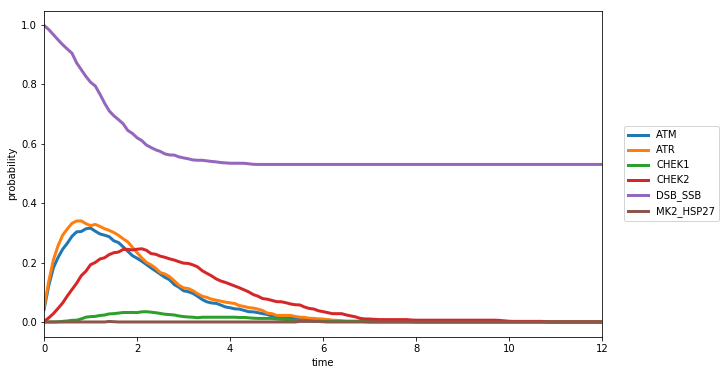

In [128]:
# plot of cell fate nodes
sel_vars=['DSB','CHEK1','CHEK2',"MK2_HSP27",'ATM','ATR'] 
# ['RAS','BRAF','CHEK1','MK2','mitos','apopt','senesc','DSB']; 
fig_pars=[3,10,6,"time","probability",12]
plot_node_dynamics(master_results,sel_vars,fig_pars)

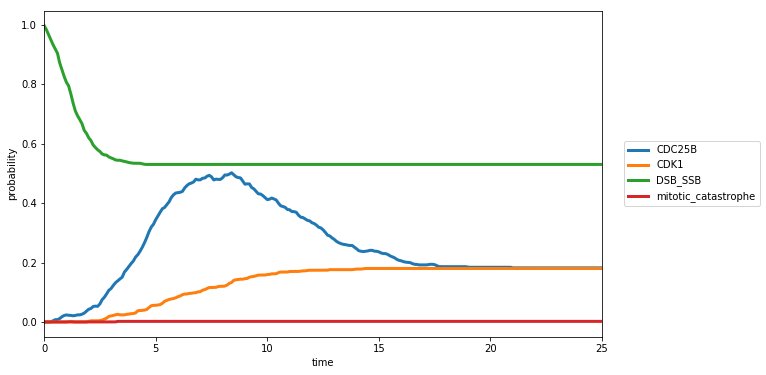

In [129]:
# nodes of mitotic catastrophe
sel_vars=['DSB','CDC25B','CDK1','mitotic_catastrophe']; fig_pars=[3,10,6,"time","probability",25]
plot_node_dynamics(master_results,sel_vars,fig_pars)

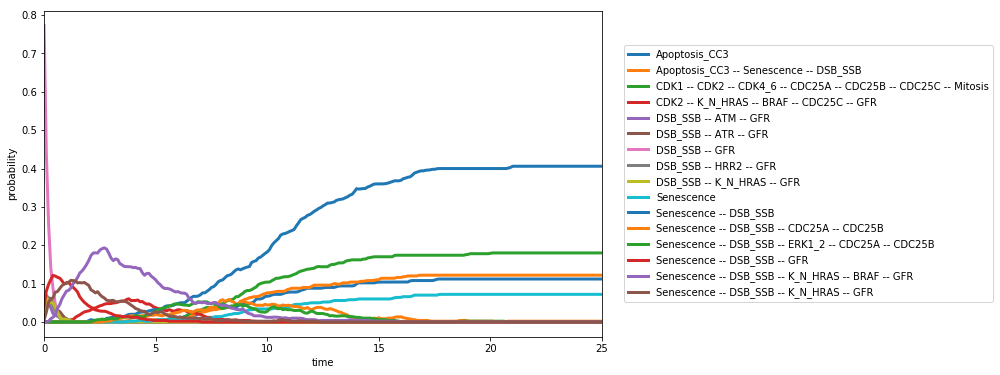

In [130]:


# show states that have >0.1 prob at any time point
# fig_pars=[3,10,6,"time","probability"];
plot_states_larger_prob_x(master_results,0.05,[3,10,6,"time","probability",25])

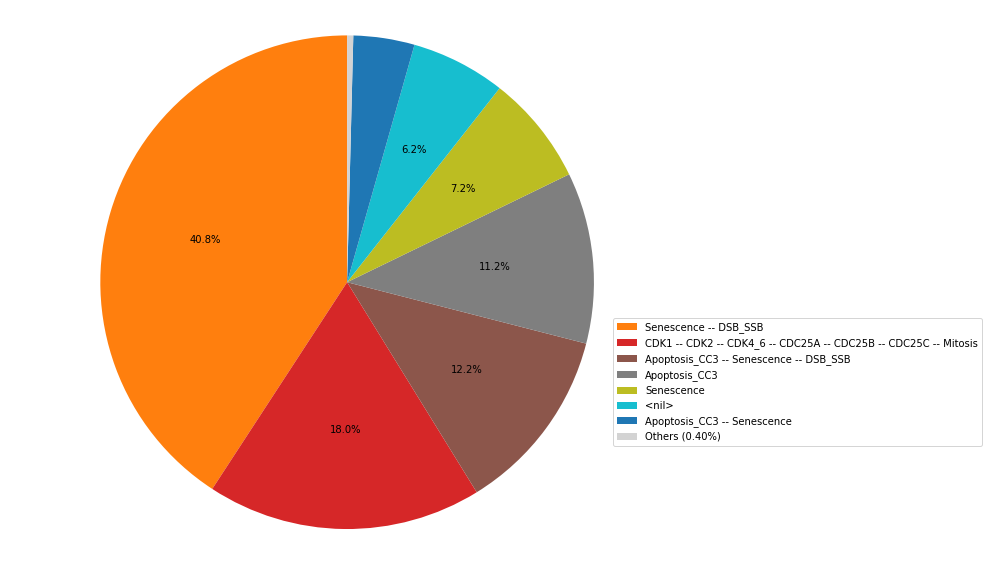

In [131]:
# piechart of fixpoints
master_results.plot_piechart()
fig_state_piechart=plt.gcf(); fig_state_piechart.set_size_inches(12,10);

In [132]:
# fixed points/attractors
fptable=master_results.get_fptable()
sel_vars=['TP','apopt','senesc','SSB','mit','Proba','CDK','CDC25','MK2']
fptable.iloc[:,fptable.columns.str.contains('|'.join(sel_vars),case=False)] 

,Proba,Apoptosis_CC3,mitotic_catastrophe,TP53,CDK1,CDK2,CDK4_6,Senescence,DSB_SSB,CDC25A,MK2_HSP27,CDC25B,CDC25C,Mitosis
0,0.062,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0.112,1,0,0,0,0,0,0,0,0,0,0,0,0
2,0.072,0,0,0,0,0,0,1,0,0,0,0,0,0
3,0.040,1,0,0,0,0,0,1,0,0,0,0,0,0
4,0.408,0,0,0,0,0,0,1,1,0,0,0,0,0
5,0.122,1,0,0,0,0,0,1,1,0,0,0,0,0
6,0.002,1,0,0,0,0,0,0,0,0,0,0,0,1
7,0.002,1,1,0,0,0,0,0,0,0,0,0,0,1
8,0.180,0,0,0,1,1,1,0,0,1,0,1,1,1


### Cell fate dynamics

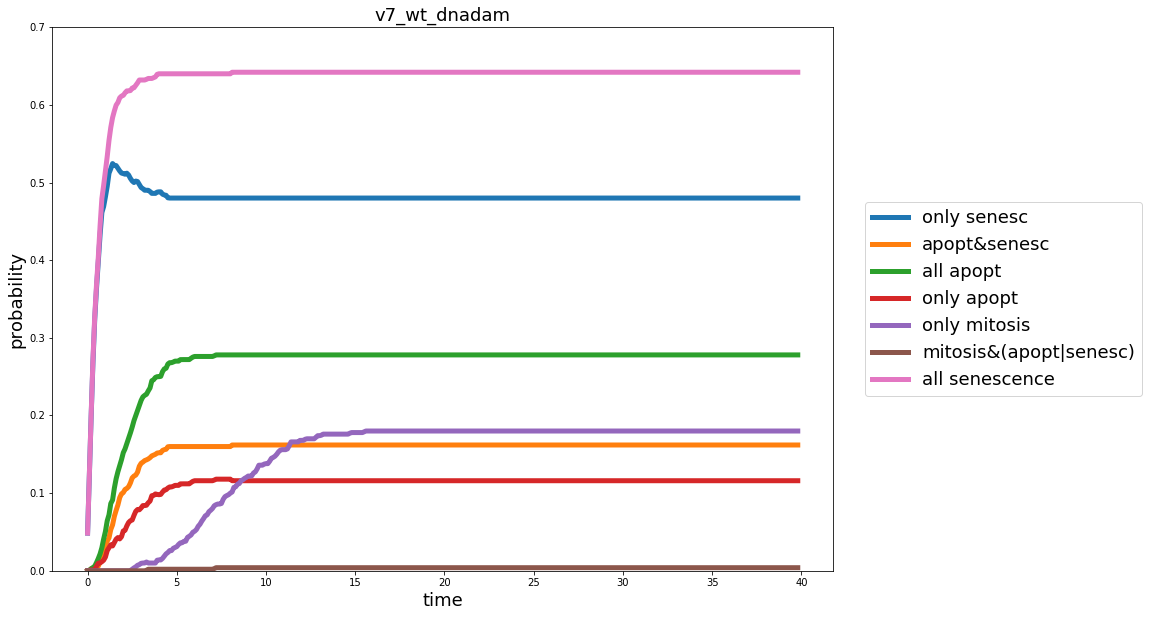

In [133]:
# states_probtraj
states_probtraj=master_results.get_states_probtraj()
string_cellfates=["Apopt","Senesc","Mitos"]
cellfate_truthvals=fcn_truthval_states(states_probtraj,string_cellfates)
[apopt_cols,senesc_cols,mitosis_cols]=cellfate_truthvals

list_truthval=[~apopt_cols & senesc_cols,apopt_cols&senesc_cols,apopt_cols,apopt_cols&~senesc_cols,
               mitosis_cols&~apopt_cols&~senesc_cols,mitosis_cols&(apopt_cols|senesc_cols),senesc_cols]
list_labels=["only senesc","apopt&senesc","all apopt","only apopt",
             "only mitosis","mitosis&(apopt|senesc)","all senescence"]

str_plotname="_wt_dnadam"; plot_pars=[14,10,18,5,0.7]
plot_cell_fates(states_probtraj,model_name,str_plotname,plot_pars,list_truthval,list_labels,"")


### Without DNA damage

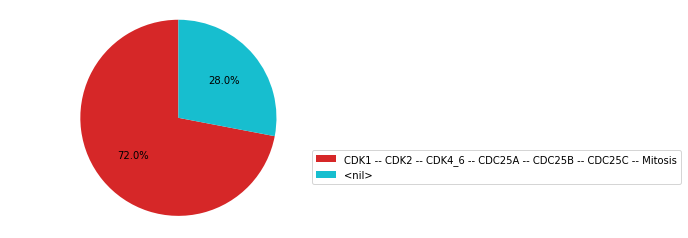

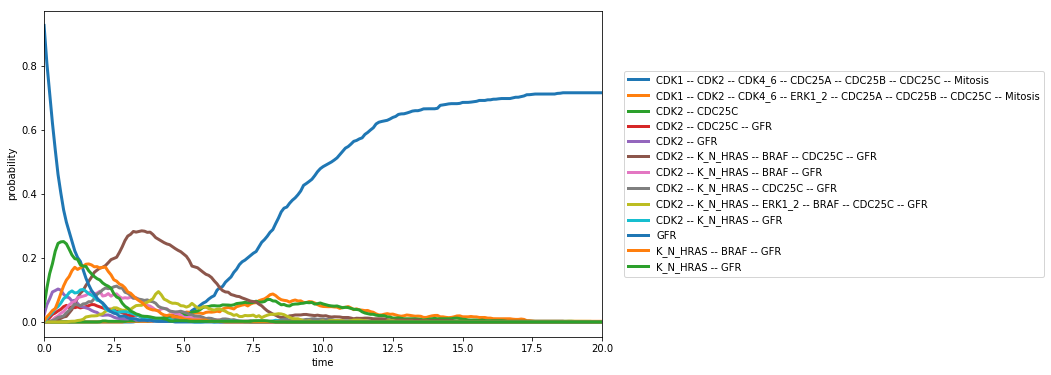

In [134]:
wt_nodnadam_model = model.copy() # maboss.copy_and_mutate(mutant_simulation, ["K_N_HRAS"], "ON")
# turn off DNA damage
wt_nodnadam_model.network.set_istate("DSB_SSB",[1,0])
wt_nodnadam_results = wt_nodnadam_model.run(); 
states_probtraj_wt_nodnadam=wt_nodnadam_results.get_states_probtraj()

# wt_nodnadam_results.get_fptable()
# wt_nodnadam_model.network.get_istate()
# model.network.get_istate()
wt_nodnadam_results.plot_piechart()
# fig_state_piechart=plt.gcf(); fig_state_piechart.set_size_inches(12,10);

# states_probtraj_wt_nodnadam.loc[:,np.sum(states_probtraj_wt_nodnadam>0.05)>0].plot(linewidth=3)
# & (states_probtraj.columns!='<nil>')
# fig_statetraj=plt.gcf(); fig_statetraj.set_size_inches(10,6);
# plt.legend(bbox_to_anchor=(1.04,0.5),loc="center left",borderaxespad=0)
plot_states_larger_prob_x(wt_nodnadam_results,0.05,[3,10,6,"time","probability",20])

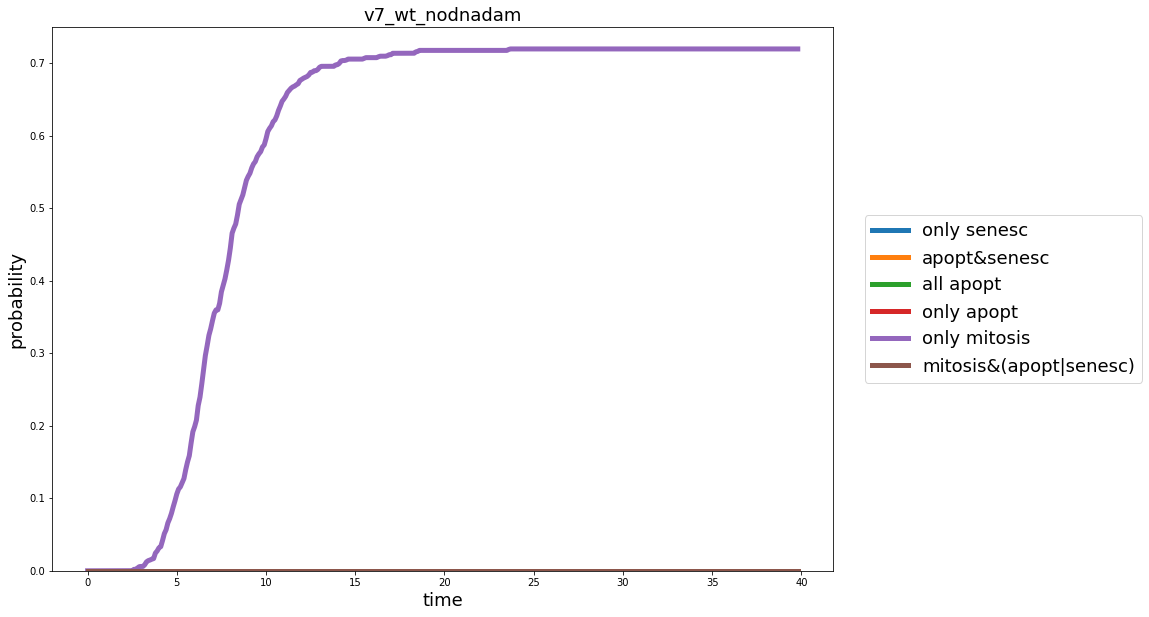

In [135]:
cellfate_truthvals=fcn_truthval_states(states_probtraj_wt_nodnadam,string_cellfates)
[apopt_cols,senesc_cols,mitosis_cols]=cellfate_truthvals

list_truthval=[~apopt_cols&senesc_cols,apopt_cols&senesc_cols,
               apopt_cols,apopt_cols&~senesc_cols,
               mitosis_cols&~apopt_cols&~senesc_cols, mitosis_cols&(apopt_cols|senesc_cols)]
list_labels=["only senesc","apopt&senesc","all apopt","only apopt","only mitosis","mitosis&(apopt|senesc)"]

str_plotname="_wt_nodnadam"; plot_pars=[14,10,18,5,0.75]
plot_cell_fates(states_probtraj_wt_nodnadam,model_name,str_plotname,plot_pars,list_truthval,list_labels,"")

## Introducing mutations: KRAS mutant

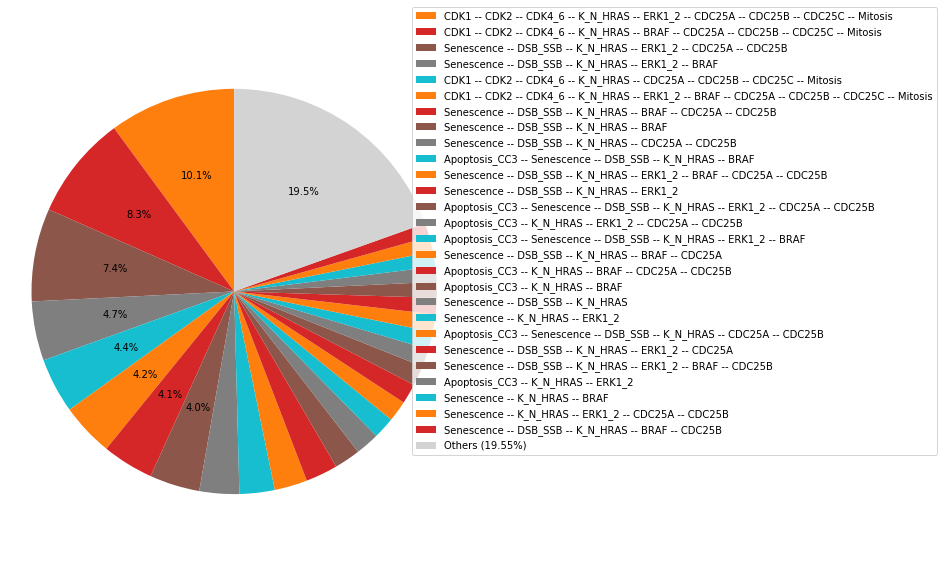

In [136]:
# introduce mutation
mutant_simulation=maboss.copy_and_mutate(model, ["K_N_HRAS"], "ON")
mutant_simulation.network.set_istate("K_N_HRAS",[0,1])
mutant_simulation.network.set_istate("DSB_SSB",[0,1])
# mutant_simulation.mutate("ATM", "OFF")
# genes=["ATM","ATR"]
# for gene in genes:
#    mutant_simulation.mutate(gene, "OFF")
#
# transfer initial states
# maboss.widgets.network.wg_transfer_istate(mutant_simulation.network, model)
# model.oneshot_mutations_for_cut(Metastasis=1, exclude={"DNAdamage", "ECMicroenv"})

mutant_results = mutant_simulation.run()

# PLOT results
mutant_results.plot_piechart()
# mutant_results.plot_fixpoint()
fig_state_piechart=plt.gcf(); fig_state_piechart.set_size_inches(8,10)

In [137]:
# state trajectories
states_probtraj_krasmutant=mutant_results.get_states_probtraj()
# table of attractors
fptable=mutant_results.get_fptable()
sel_vars=['TP','apopt','senesc','SSB','mit','Proba','CDK','CDC25','MK2']
# fixed point table is empty (because system is oscillating)
# fptable.iloc[:,fptable.columns.str.contains('|'.join(sel_vars),case=False)]
finalstates=mutant_results.get_last_states_probtraj()
np.round(finalstates.loc[:,finalstates.iloc[0,:].values>0.03],decimals=3)

,CDK1 -- CDK2 -- CDK4_6 -- K_N_HRAS -- BRAF -- CDC25A -- CDC25B -- CDC25C -- Mitosis,CDK1 -- CDK2 -- CDK4_6 -- K_N_HRAS -- CDC25A -- CDC25B -- CDC25C -- Mitosis,CDK1 -- CDK2 -- CDK4_6 -- K_N_HRAS -- ERK1_2 -- BRAF -- CDC25A -- CDC25B -- CDC25C -- Mitosis,CDK1 -- CDK2 -- CDK4_6 -- K_N_HRAS -- ERK1_2 -- CDC25A -- CDC25B -- CDC25C -- Mitosis,Senescence -- DSB_SSB -- K_N_HRAS -- BRAF,Senescence -- DSB_SSB -- K_N_HRAS -- BRAF -- CDC25A -- CDC25B,Senescence -- DSB_SSB -- K_N_HRAS -- CDC25A -- CDC25B,Senescence -- DSB_SSB -- K_N_HRAS -- ERK1_2 -- BRAF,Senescence -- DSB_SSB -- K_N_HRAS -- ERK1_2 -- CDC25A -- CDC25B
39.9000,0.083,0.044,0.042,0.101,0.04,0.041,0.032,0.047,0.074


### Cell fate dynamics: KRAS$\Delta$ with DNAdam

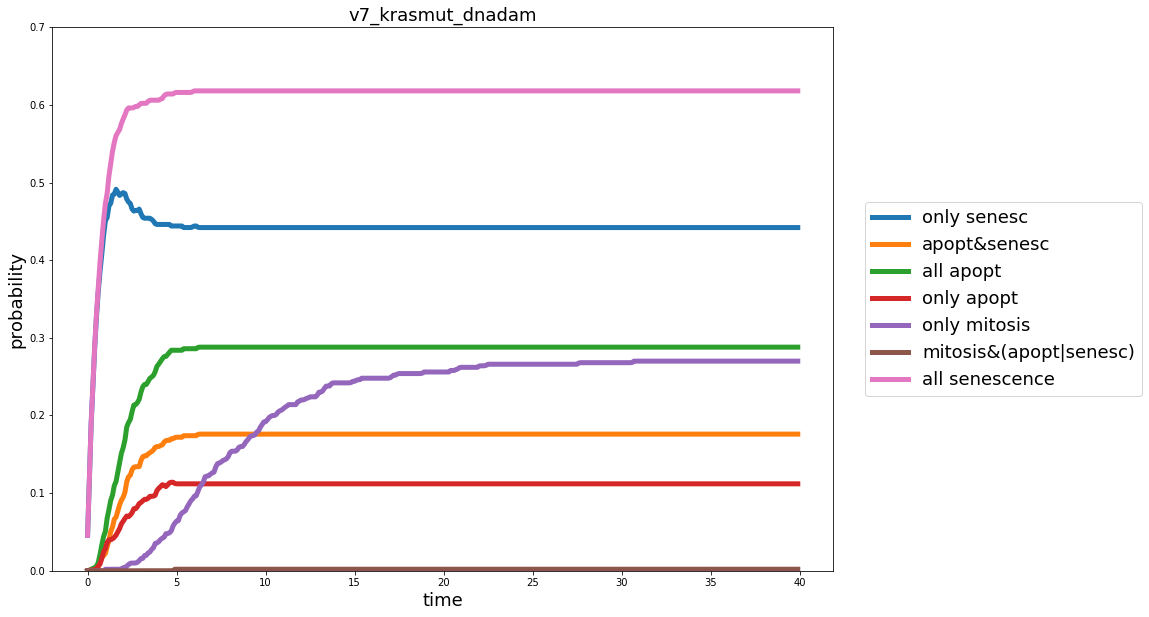

In [138]:
# sum of columns
nonzero_states=np.sum(states_probtraj_krasmutant.iloc[-1:,]>0)>0
# take sum of columns containing Apoptosis, Senescence, Mitosis
cellfate_truthvals=fcn_truthval_states(states_probtraj_krasmutant,string_cellfates)
[apopt_cols,senesc_cols,mitosis_cols]=cellfate_truthvals

list_truthval=[~apopt_cols & senesc_cols,apopt_cols&senesc_cols,apopt_cols,apopt_cols&~senesc_cols,
               mitosis_cols&~apopt_cols&~senesc_cols,mitosis_cols&(apopt_cols|senesc_cols),senesc_cols]
list_labels=["only senesc","apopt&senesc","all apopt","only apopt",
             "only mitosis","mitosis&(apopt|senesc)","all senescence"]

str_plotname="_krasmut_dnadam"; plot_pars=[14,10,18,5,0.7]
plot_cell_fates(states_probtraj_krasmutant,model_name,str_plotname,plot_pars,list_truthval,list_labels,"save")

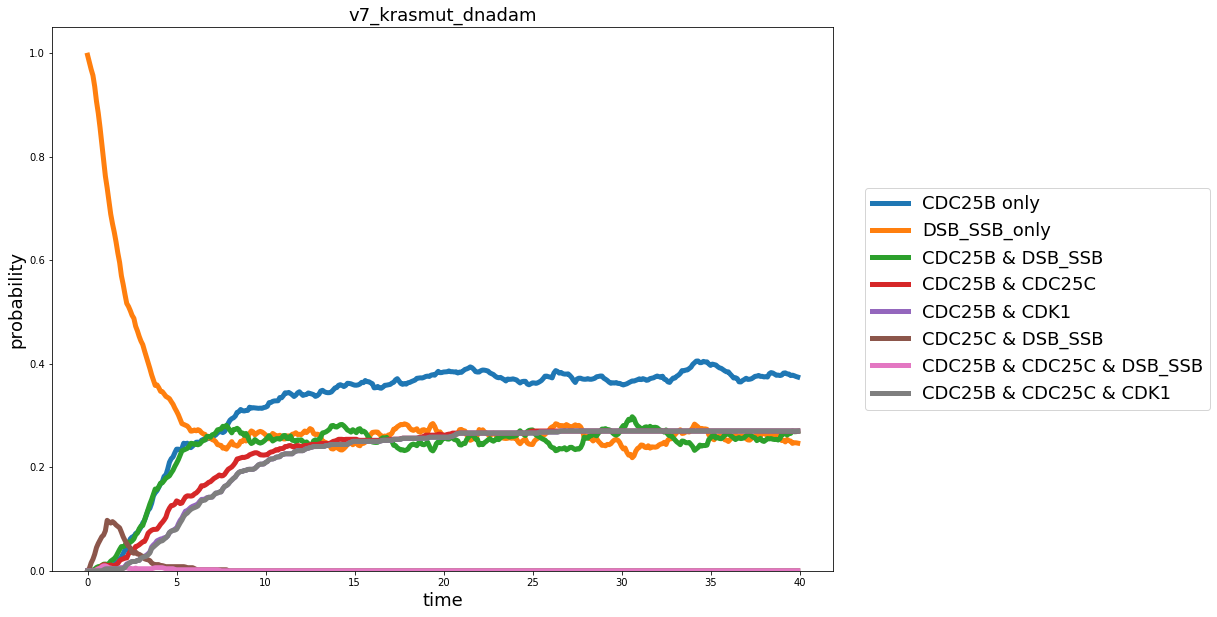

In [139]:
string_cellfates=["CDC25B","DSB_SSB","CDC25C","CDK1"]
truthval_states=fcn_truthval_states(states_probtraj_krasmutant,string_cellfates)

list_truthval=[truthval_states[0]&~truthval_states[1],
               truthval_states[1]&~truthval_states[0],
               truthval_states[0]&truthval_states[1],
               truthval_states[0]&truthval_states[2],
               truthval_states[0]&truthval_states[3],
               truthval_states[1]&truthval_states[2],
              truthval_states[0]&truthval_states[1]&truthval_states[2],
              truthval_states[0]&truthval_states[2]&truthval_states[3]]
list_labels=["CDC25B only","DSB_SSB_only", 
             "CDC25B & DSB_SSB","CDC25B & CDC25C",
             "CDC25B & CDK1", "CDC25C & DSB_SSB",
             "CDC25B & CDC25C & DSB_SSB",
             "CDC25B & CDC25C & CDK1"]

str_plotname="_krasmut_dnadam"; plot_pars=[14,10,18,5,1.05]; plot_name=model_name+str_plotname+"cdc25_dsb_states"
plot_cell_fates(states_probtraj_krasmutant,model_name,str_plotname,plot_pars,list_truthval,list_labels,"")
plt.savefig("figures/"+plot_name+".png",bbox_inches='tight')

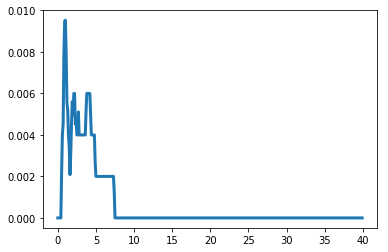

In [140]:
truthval=states_probtraj_krasmutant.columns.str.contains("CDC25B") & \
        states_probtraj_krasmutant.columns.str.contains("CDC25C") & \
        states_probtraj_krasmutant.columns.str.contains("DSB_SSB")

np.sum(states_probtraj_krasmutant.loc[:,truthval],axis=1).plot(linewidth=3)

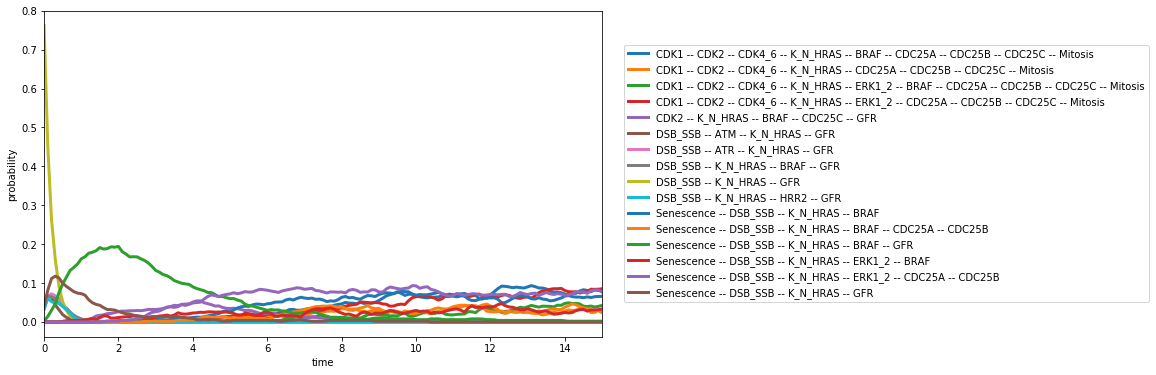

In [141]:
plot_states_larger_prob_x(mutant_results,0.05,[3,10,6,"time","probability",15])

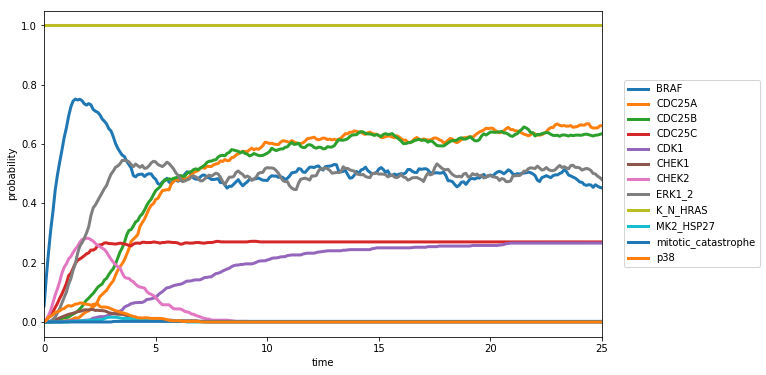

In [142]:
# node dynamics
sel_vars=['RAS','BRAF','CHEK','ERK','MK2',"CDK1","CDC25","p38",'mitot'] # ,'mito','apopt','senesc','DSB',
# ['mit','apopt','senesc','DSB','CDK1','TP53','CHEK','MK2','ATM','ATR','AKT']
fig_pars=[3,10,6,"time","probability",25]
plot_node_dynamics(mutant_results,sel_vars,fig_pars)

### KRAS$\Delta$ without DNA damage

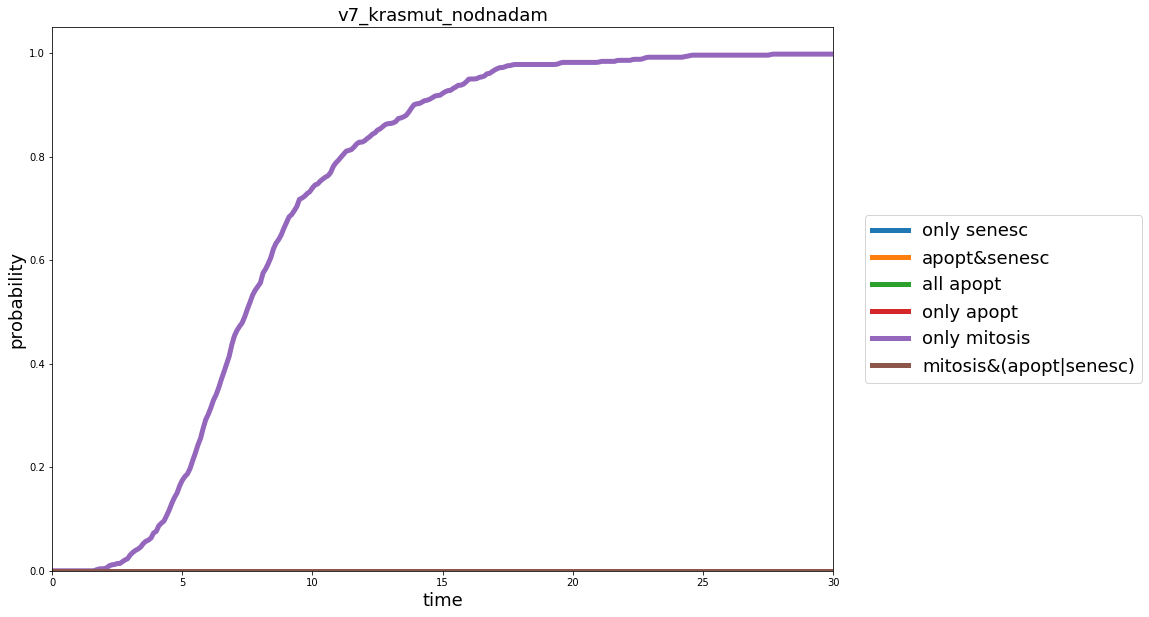

In [143]:
krasmut_nodnadam_model=mutant_simulation.copy() # maboss.copy_and_mutate(mutant_simulation, ["K_N_HRAS"], "ON")
# turn off DNA damage
krasmut_nodnadam_model.network.set_istate("DSB_SSB",[1,0]); krasmut_nodnadam_results=krasmut_nodnadam_model.run(); 
states_probtraj_krasmut_nodnadam=krasmut_nodnadam_results.get_states_probtraj()

string_cellfates=["Apopt","Senesc","Mitos"]
cellfate_truthvals=fcn_truthval_states(states_probtraj_krasmut_nodnadam,string_cellfates)
[apopt_cols,senesc_cols,mitosis_cols]=cellfate_truthvals

list_truthval=[~apopt_cols & senesc_cols,apopt_cols&senesc_cols,apopt_cols,apopt_cols&~senesc_cols,
               mitosis_cols&~apopt_cols&~senesc_cols,mitosis_cols&(apopt_cols|senesc_cols)]
list_labels=["only senesc","apopt&senesc","all apopt","only apopt","only mitosis","mitosis&(apopt|senesc)"]

str_plotname="_krasmut_nodnadam"; plot_pars=[14,10,18,5,1.05,30]
plot_cell_fates(states_probtraj_krasmut_nodnadam,model_name,str_plotname,plot_pars,list_truthval,list_labels,"")

### Block CHEK 1

In [144]:
krasmut_dnadam_chek1off_model=maboss.copy_and_mutate(mutant_simulation, ["CHEK1"], "OFF")
krasmut_dnadam_chek1off_results = krasmut_dnadam_chek1off_model.run(); 
states_probtraj_krasmut_dnadam_chek1off=krasmut_dnadam_chek1off_results.get_states_probtraj()
# krasmut_dnadam_chek1off_model.network.set_istate("DSB_SSB",[0,1])

finalstates=krasmut_dnadam_chek1off_results.get_last_states_probtraj()
np.round(finalstates.loc[:,finalstates.iloc[0,:].values>0.03],decimals=3)

krasmut_dnadam_chek1off_model.get_mutations()

{'CHEK1': 'OFF'}

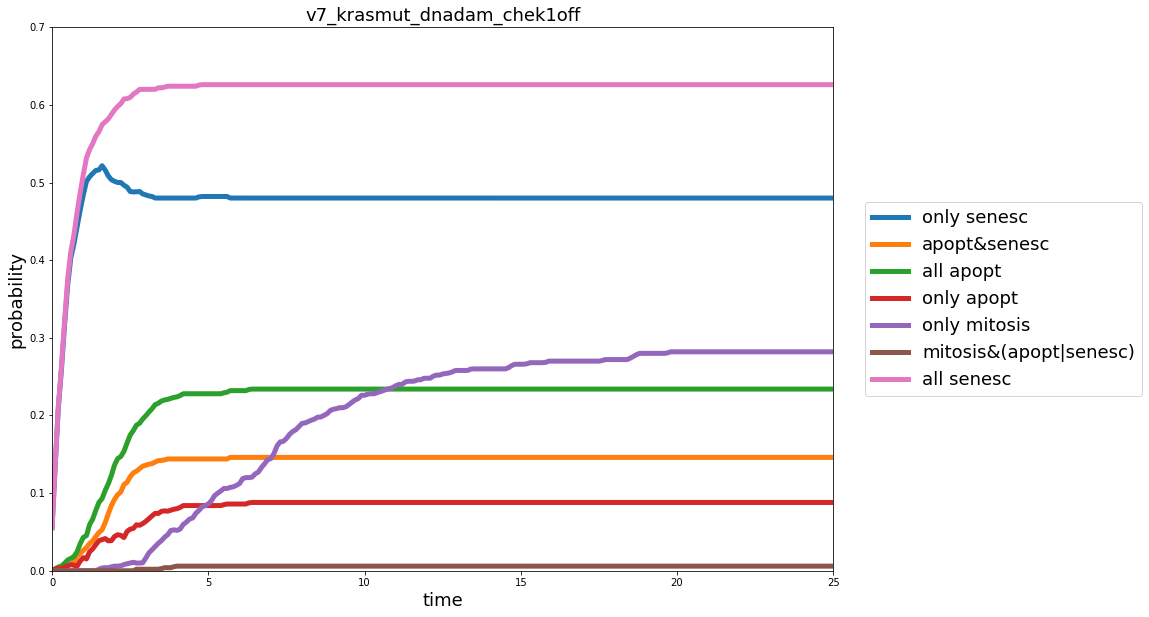

In [145]:
cellfate_truthvals=fcn_truthval_states(states_probtraj_krasmut_dnadam_chek1off,["Apopt","Senesc","Mitos"])
[apopt_cols,senesc_cols,mitosis_cols]=cellfate_truthvals

list_truthval=[~apopt_cols & senesc_cols,apopt_cols&senesc_cols,apopt_cols,apopt_cols&~senesc_cols,
               mitosis_cols&~apopt_cols&~senesc_cols,mitosis_cols&(apopt_cols|senesc_cols),senesc_cols]
list_labels=["only senesc","apopt&senesc","all apopt","only apopt","only mitosis",
             "mitosis&(apopt|senesc)","all senesc"]

str_plotname="_krasmut_dnadam_chek1off"; plot_pars=[14,10,18,5,0.7,25]
plot_cell_fates(states_probtraj_krasmut_dnadam_chek1off,model_name,str_plotname,
                plot_pars,list_truthval,list_labels,"")

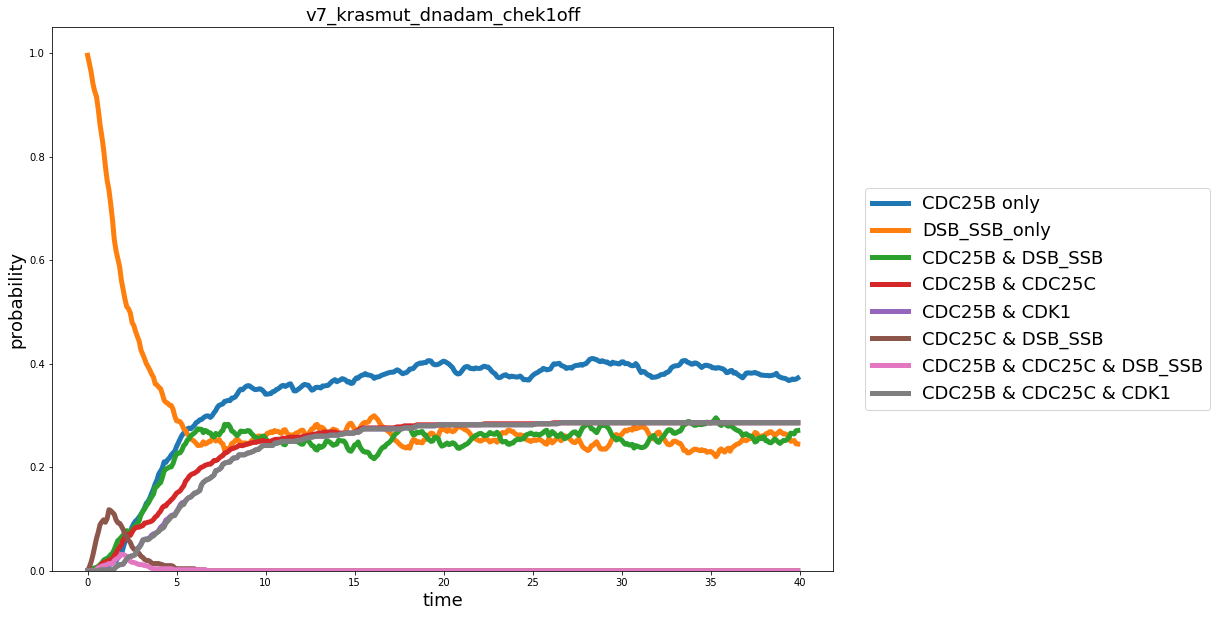

In [146]:
string_cellfates=["CDC25B","DSB_SSB","CDC25C","CDK1"]
truthval_states=fcn_truthval_states(states_probtraj_krasmut_dnadam_chek1off,string_cellfates)

list_truthval=[truthval_states[0]&~truthval_states[1],
               truthval_states[1]&~truthval_states[0],
               truthval_states[0]&truthval_states[1],
               truthval_states[0]&truthval_states[2],
               truthval_states[0]&truthval_states[3],
               truthval_states[1]&truthval_states[2],
              truthval_states[0]&truthval_states[1]&truthval_states[2],
              truthval_states[0]&truthval_states[2]&truthval_states[3]]
list_labels=["CDC25B only", "DSB_SSB_only", 
             "CDC25B & DSB_SSB","CDC25B & CDC25C",
             "CDC25B & CDK1", "CDC25C & DSB_SSB",
             "CDC25B & CDC25C & DSB_SSB",
            "CDC25B & CDC25C & CDK1"]

str_plotname="_krasmut_dnadam_chek1off"; plot_pars=[14,10,18,5,1.05]
plot_cell_fates(states_probtraj_krasmut_dnadam_chek1off,model_name,str_plotname,
                plot_pars,list_truthval,list_labels,"")

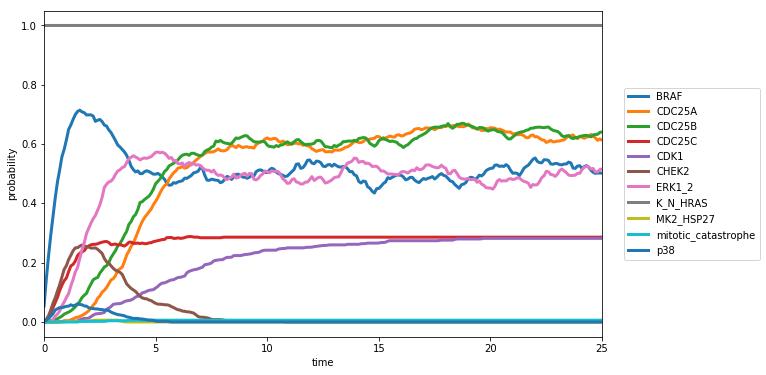

In [147]:
sel_vars=['RAS','BRAF','CHEK','ERK','MK2',"CDK1","CDC25","p38",'mitot'] # ,'mito','apopt','senesc','DSB',
# ['mit','apopt','senesc','DSB','CDK1','TP53','CHEK','MK2','ATM','ATR','AKT']
fig_pars=[3,10,6,"time","probability",25]
plot_node_dynamics(krasmut_dnadam_chek1off_results,sel_vars,fig_pars)

### MK2 blocked

In [148]:
krasmut_dnadam_mk2off_model=maboss.copy_and_mutate(mutant_simulation, ["MK2_HSP27"], "OFF")
krasmut_dnadam_mk2off_results = krasmut_dnadam_mk2off_model.run(); 
states_probtraj_krasmut_dnadam_mk2off=krasmut_dnadam_mk2off_results.get_states_probtraj()
# krasmut_dnadam_mk2off_model.network.set_istate("DSB_SSB",[0,1])

finalstates=krasmut_dnadam_mk2off_results.get_last_states_probtraj()
np.round(finalstates.loc[:,finalstates.iloc[0,:].values>0.03],decimals=3)

,CDK1 -- CDK2 -- CDK4_6 -- K_N_HRAS -- BRAF -- CDC25A -- CDC25B -- CDC25C -- Mitosis,CDK1 -- CDK2 -- CDK4_6 -- K_N_HRAS -- CDC25A -- CDC25B -- CDC25C -- Mitosis,CDK1 -- CDK2 -- CDK4_6 -- K_N_HRAS -- ERK1_2 -- BRAF -- CDC25A -- CDC25B -- CDC25C -- Mitosis,CDK1 -- CDK2 -- CDK4_6 -- K_N_HRAS -- ERK1_2 -- CDC25A -- CDC25B -- CDC25C -- Mitosis,Senescence -- DSB_SSB -- K_N_HRAS -- BRAF,Senescence -- DSB_SSB -- K_N_HRAS -- BRAF -- CDC25A -- CDC25B,Senescence -- DSB_SSB -- K_N_HRAS -- CDC25A -- CDC25B,Senescence -- DSB_SSB -- K_N_HRAS -- ERK1_2,Senescence -- DSB_SSB -- K_N_HRAS -- ERK1_2 -- BRAF,Senescence -- DSB_SSB -- K_N_HRAS -- ERK1_2 -- CDC25A -- CDC25B
39.9000,0.085,0.043,0.046,0.09,0.085,0.047,0.03,0.044,0.036,0.056


In [149]:
print(krasmut_dnadam_mk2off_model.network["Senescence"])

Node Senescence {

	logic = Senescence|(DSB_SSB&!(CDK1|CDK2|CDK4_6|Mitosis));
	rate_up = @logic ? $u_Senescence : 0;
	rate_down = @logic ? 0 : $d_Senescence;
}


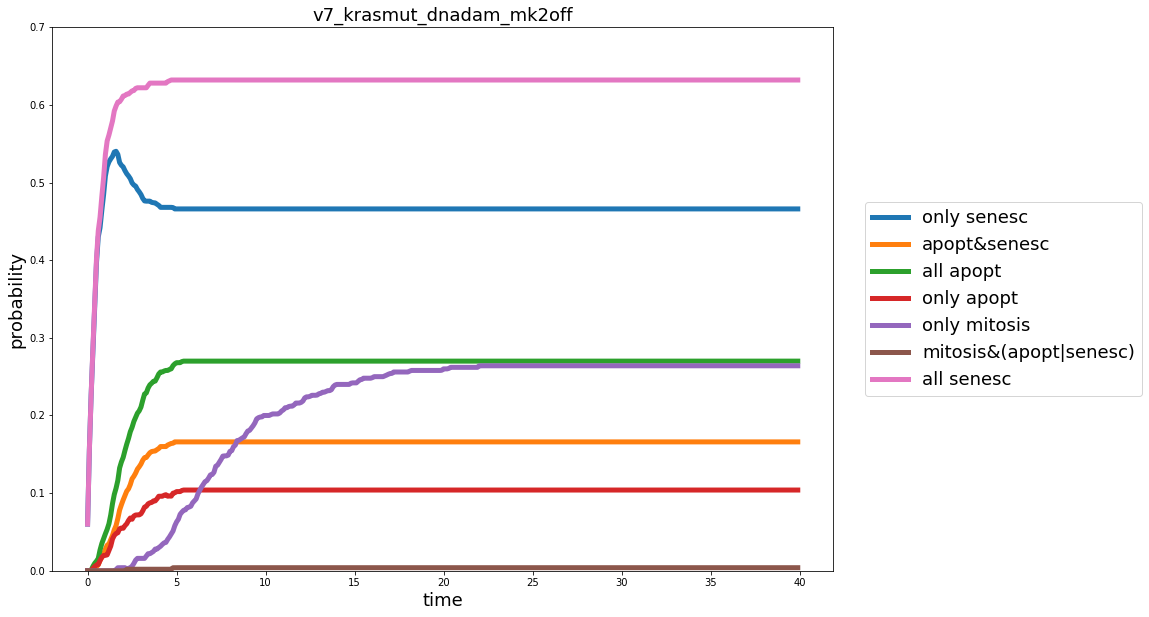

In [150]:
string_cellfates=["Apopt","Senesc","Mitos"]
cellfate_truthvals=fcn_truthval_states(states_probtraj_krasmut_dnadam_mk2off,string_cellfates)   
[apopt_cols,senesc_cols,mitosis_cols]=cellfate_truthvals

list_truthval=[~apopt_cols & senesc_cols,apopt_cols&senesc_cols,apopt_cols,apopt_cols&~senesc_cols,
           mitosis_cols&~apopt_cols&~senesc_cols,mitosis_cols&(apopt_cols|senesc_cols),senesc_cols]
list_labels=["only senesc","apopt&senesc","all apopt","only apopt",
             "only mitosis","mitosis&(apopt|senesc)","all senesc"]

str_plotname="_krasmut_dnadam_mk2off"; plot_pars=[14,10,18,5,0.7]
plot_cell_fates(states_probtraj_krasmut_dnadam_mk2off,model_name,str_plotname,
                plot_pars,list_truthval,list_labels,"")

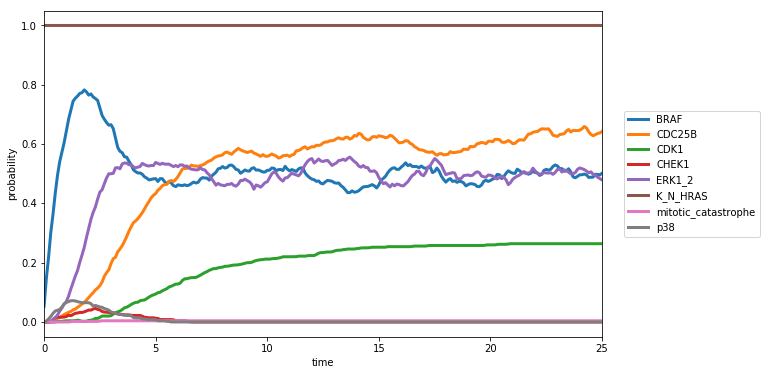

In [151]:
sel_vars=['RAS','BRAF','CHEK1','ERK','MK2',"CDK1","CDC25B","p38",'mitot'] # ,'mito','apopt','senesc','DSB',
# ['mit','apopt','senesc','DSB','CDK1','TP53','CHEK','MK2','ATM','ATR','AKT']
fig_pars=[3,10,6,"time","probability",25]
plot_node_dynamics(krasmut_dnadam_mk2off_results,sel_vars,fig_pars)

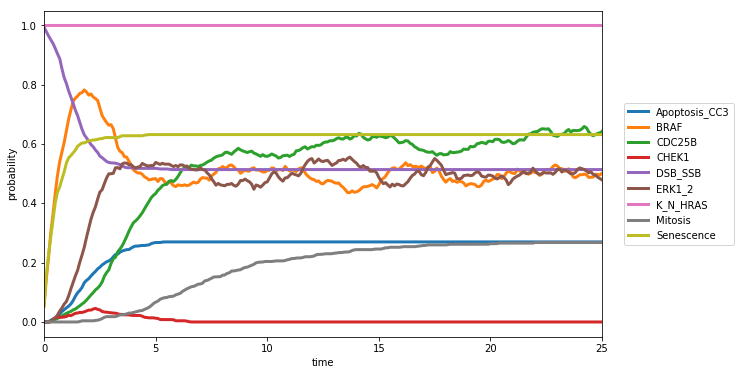

In [152]:
# nodes_probtraj=master_results.get_nodes_probtraj()
sel_vars=['RAS','BRAF','CHEK1','MK2','mitos','apopt','senesc','DSB','ERK','CDC25B'] # 'p38','ERK'
fig_pars=[3,10,6,"time","probability",25]
plot_node_dynamics(krasmut_dnadam_mk2off_results,sel_vars,fig_pars)

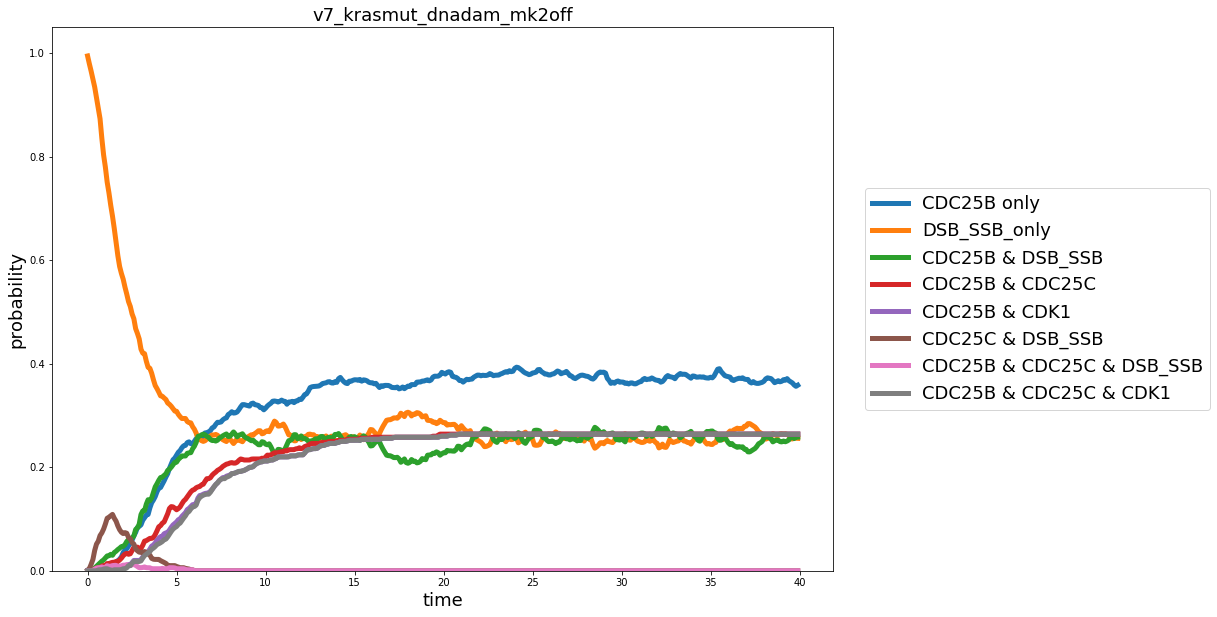

In [153]:
string_cellfates=["CDC25B","DSB_SSB","CDC25C","CDK1"]
truthval_states=fcn_truthval_states(states_probtraj_krasmut_dnadam_mk2off,string_cellfates)

list_truthval=[truthval_states[0]&~truthval_states[1],
               truthval_states[1]&~truthval_states[0],
               truthval_states[0]&truthval_states[1],
               truthval_states[0]&truthval_states[2],
               truthval_states[0]&truthval_states[3],
               truthval_states[1]&truthval_states[2],
              truthval_states[0]&truthval_states[1]&truthval_states[2],
              truthval_states[0]&truthval_states[2]&truthval_states[3]]
list_labels=["CDC25B only", "DSB_SSB_only", 
             "CDC25B & DSB_SSB","CDC25B & CDC25C",
             "CDC25B & CDK1", "CDC25C & DSB_SSB",
             "CDC25B & CDC25C & DSB_SSB",
            "CDC25B & CDC25C & CDK1"]

str_plotname="_krasmut_dnadam_mk2off"; plot_pars=[14,10,18,5,1.05]
plot_cell_fates(states_probtraj_krasmut_dnadam_mk2off,model_name,str_plotname,plot_pars,list_truthval,list_labels,"")

### CHEK1 and MK2 both blocked

In [154]:
krasmut_dnadam_chek1off_mk2off_model=maboss.copy_and_mutate(mutant_simulation, ["CHEK1","MK2_HSP27"], "OFF")
krasmut_dnadam_chek1off_mk2off_results = krasmut_dnadam_chek1off_mk2off_model.run(); 
states_probtraj_krasmut_dnadam_chek1off_mk2off=krasmut_dnadam_chek1off_mk2off_results.get_states_probtraj()
# krasmut_dnadam_chek1off_mk2off_model.network.set_istate("DSB_SSB",[0,1])
# krasmut_dnadam_chek1off_mk2off_model.get_mutations()

finalstates=krasmut_dnadam_chek1off_mk2off_results.get_last_states_probtraj()
np.round(finalstates.loc[:,finalstates.iloc[0,:].values>0.03],decimals=3)

,CDK1 -- CDK2 -- CDK4_6 -- K_N_HRAS -- BRAF -- CDC25A -- CDC25B -- CDC25C -- Mitosis,CDK1 -- CDK2 -- CDK4_6 -- K_N_HRAS -- CDC25A -- CDC25B -- CDC25C -- Mitosis,CDK1 -- CDK2 -- CDK4_6 -- K_N_HRAS -- ERK1_2 -- BRAF -- CDC25A -- CDC25B -- CDC25C -- Mitosis,CDK1 -- CDK2 -- CDK4_6 -- K_N_HRAS -- ERK1_2 -- CDC25A -- CDC25B -- CDC25C -- Mitosis,Senescence -- DSB_SSB -- K_N_HRAS -- BRAF,Senescence -- DSB_SSB -- K_N_HRAS -- CDC25A -- CDC25B,Senescence -- DSB_SSB -- K_N_HRAS -- ERK1_2,Senescence -- DSB_SSB -- K_N_HRAS -- ERK1_2 -- BRAF,Senescence -- DSB_SSB -- K_N_HRAS -- ERK1_2 -- CDC25A -- CDC25B
39.9000,0.083,0.046,0.044,0.091,0.065,0.034,0.042,0.042,0.081


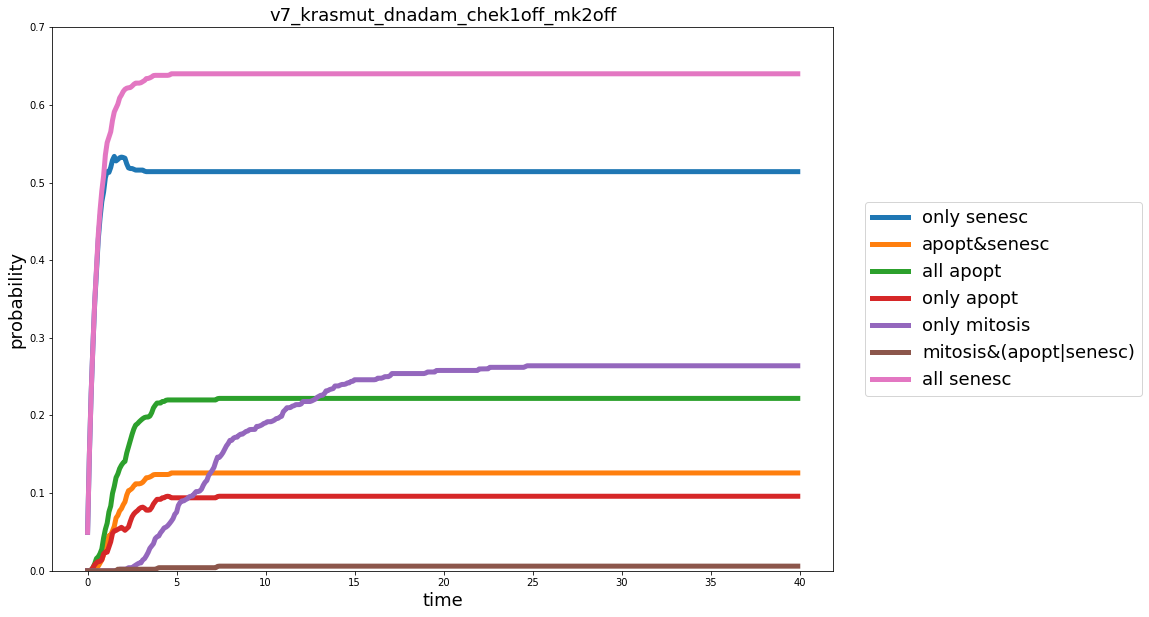

In [155]:
string_cellfates=["Apopt","Senesc","Mitos"]
cellfate_truthvals=fcn_truthval_states(states_probtraj_krasmut_dnadam_chek1off_mk2off,string_cellfates)   
[apopt_cols,senesc_cols,mitosis_cols]=cellfate_truthvals

list_truthval=[~apopt_cols&senesc_cols, apopt_cols&senesc_cols, apopt_cols, apopt_cols&~senesc_cols,
           mitosis_cols&~apopt_cols&~senesc_cols,mitosis_cols&(apopt_cols|senesc_cols),senesc_cols]
list_labels=["only senesc","apopt&senesc","all apopt","only apopt",
             "only mitosis","mitosis&(apopt|senesc)","all senesc"]

str_plotname="_krasmut_dnadam_chek1off_mk2off"; plot_pars=[14,10,18,5,0.7]
plot_cell_fates(states_probtraj_krasmut_dnadam_chek1off_mk2off,model_name,str_plotname,plot_pars,
                list_truthval,list_labels,"")

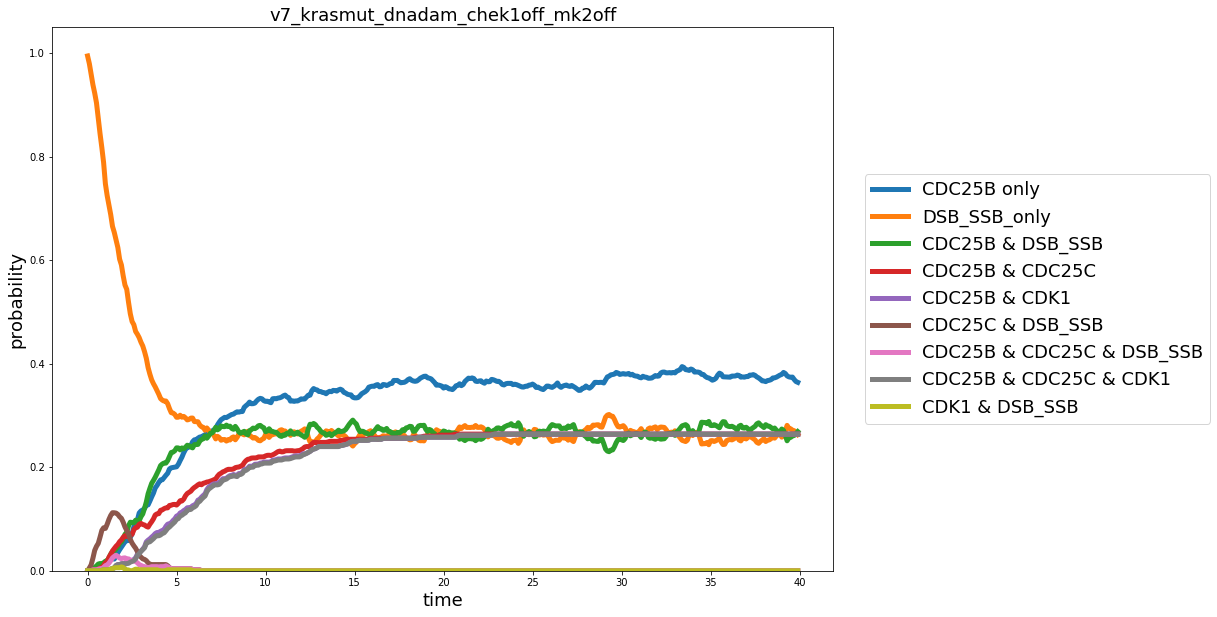

In [156]:
string_cellfates=["CDC25B","DSB_SSB","CDC25C","CDK1"]
truthval_states=fcn_truthval_states(states_probtraj_krasmut_dnadam_chek1off_mk2off,string_cellfates)
[CDC25B_states,DSB_SSB_states,CDC25C_states,CDK1_states]=truthval_states

list_truthval=[CDC25B_states&~DSB_SSB_states,
               DSB_SSB_states&~CDC25B_states,
               CDC25B_states&DSB_SSB_states,
               CDC25B_states&CDC25C_states,
               CDC25B_states&CDK1_states,
               DSB_SSB_states&CDC25C_states,
              CDC25B_states&DSB_SSB_states&CDC25C_states,
              CDC25B_states&CDC25C_states&CDK1_states, CDK1_states&DSB_SSB_states]
list_labels=["CDC25B only", "DSB_SSB_only", 
             "CDC25B & DSB_SSB","CDC25B & CDC25C",
             "CDC25B & CDK1", "CDC25C & DSB_SSB",
             "CDC25B & CDC25C & DSB_SSB",
            "CDC25B & CDC25C & CDK1", "CDK1 & DSB_SSB"]

str_plotname="_krasmut_dnadam_chek1off_mk2off"; plot_pars=[14,10,18,5,1.05]
plot_cell_fates(states_probtraj_krasmut_dnadam_chek1off_mk2off,model_name,str_plotname,plot_pars,
                list_truthval,list_labels,"")

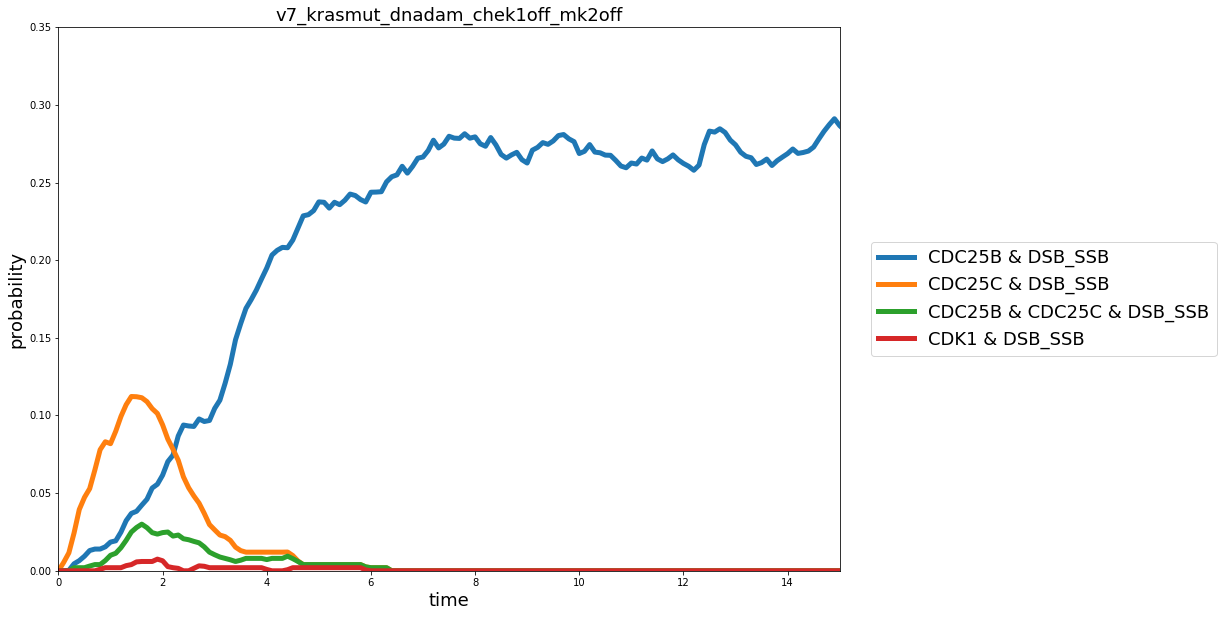

In [157]:
list_truthval=[CDC25B_states&DSB_SSB_states, CDC25C_states&DSB_SSB_states, CDC25B_states&CDC25C_states&DSB_SSB_states,
               CDK1_states&DSB_SSB_states]
list_labels=["CDC25B & DSB_SSB", "CDC25C & DSB_SSB", "CDC25B & CDC25C & DSB_SSB","CDK1 & DSB_SSB"]
plot_pars=[14,10,18,5,0.35,15]
plot_cell_fates(states_probtraj_krasmut_dnadam_chek1off_mk2off,model_name,
                str_plotname,plot_pars,list_truthval,list_labels,"")

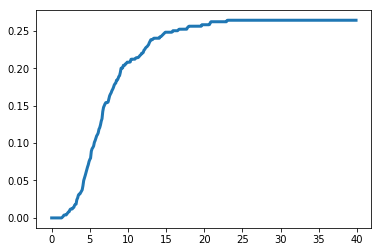

In [158]:
truthval=states_probtraj_krasmut_dnadam_chek1off_mk2off.columns.str.contains("CDC25A") & \
    states_probtraj_krasmut_dnadam_chek1off_mk2off.columns.str.contains("CDC25B") & \
    states_probtraj_krasmut_dnadam_chek1off_mk2off.columns.str.contains("CDC25C") & \
    states_probtraj_krasmut_dnadam_chek1off_mk2off.columns.str.contains("CDK1")
    # states_probtraj_krasmut_dnadam_chek1off_mk2off.columns.str.contains("DSB_SSB")

np.sum(truthval)
np.sum(states_probtraj_krasmut_dnadam_chek1off_mk2off.loc[:,truthval],axis=1).plot(linewidth=3)

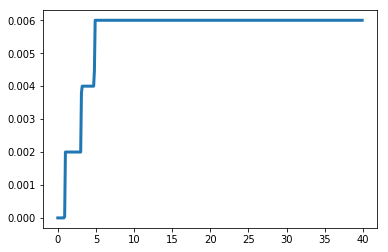

In [168]:
truthval=states_probtraj_krasmut_dnadam_chek1off_mk2off.columns.str.contains("mitotic")
np.sum(states_probtraj_krasmut_dnadam_chek1off_mk2off.loc[:,truthval],axis=1).plot(linewidth=3)

### Block MK2, CHEK1, CHEK2

In [169]:
krasmut_dnadam_chek1chek2off_mk2off_model=maboss.copy_and_mutate(mutant_simulation, ["CHEK1","CHEK2","MK2_HSP27"], "OFF")

# set a parameter
krasmut_dnadam_chek1chek2off_mk2off_model.param["$d_DSB_SSB"]=0.1 # param['$u_p53']
krasmut_dnadam_chek1chek2off_mk2off_model.param["$d_DSB_SSB"]

krasmut_dnadam_chek1chek2off_mk2off_results=krasmut_dnadam_chek1chek2off_mk2off_model.run(); 
states_probtraj_krasmut_dnadam_chek1chek2off_mk2off=krasmut_dnadam_chek1chek2off_mk2off_results.get_states_probtraj()
# krasmut_dnadam_chek1off_mk2off_model.network.set_istate("DSB_SSB",[0,1])
# krasmut_dnadam_chek1off_mk2off_model.get_mutations()

finalstates=krasmut_dnadam_chek1chek2off_mk2off_results.get_last_states_probtraj()
np.round(finalstates.loc[:,finalstates.iloc[0,:].values>0.02],decimals=3)

,Apoptosis_CC3 -- Senescence -- DSB_SSB -- K_N_HRAS -- BRAF,Apoptosis_CC3 -- Senescence -- DSB_SSB -- K_N_HRAS -- CDC25A -- CDC25B,Apoptosis_CC3 -- Senescence -- DSB_SSB -- K_N_HRAS -- ERK1_2,Apoptosis_CC3 -- Senescence -- DSB_SSB -- K_N_HRAS -- ERK1_2 -- BRAF,Apoptosis_CC3 -- Senescence -- DSB_SSB -- K_N_HRAS -- ERK1_2 -- CDC25A -- CDC25B,Senescence -- DSB_SSB -- K_N_HRAS,Senescence -- DSB_SSB -- K_N_HRAS -- BRAF,Senescence -- DSB_SSB -- K_N_HRAS -- BRAF -- CDC25A -- CDC25B,Senescence -- DSB_SSB -- K_N_HRAS -- CDC25A -- CDC25B,Senescence -- DSB_SSB -- K_N_HRAS -- ERK1_2,Senescence -- DSB_SSB -- K_N_HRAS -- ERK1_2 -- BRAF,Senescence -- DSB_SSB -- K_N_HRAS -- ERK1_2 -- CDC25A,Senescence -- DSB_SSB -- K_N_HRAS -- ERK1_2 -- CDC25A -- CDC25B
39.9000,0.055,0.023,0.023,0.024,0.04,0.026,0.121,0.043,0.039,0.045,0.028,0.023,0.119


In [170]:
fptable=krasmut_dnadam_chek1chek2off_mk2off_results.get_last_nodes_probtraj()
sel_vars=['TP','apopt','senesc','SSB','mit','Proba','CDK','CDC25','MK2']
fptable.iloc[:,fptable.columns.str.contains('|'.join(sel_vars),case=False)] 

,Apoptosis_CC3,CDC25A,CDC25B,CDC25C,CDK1,CDK2,CDK4_6,DSB_SSB,Mitosis,Senescence,mitotic_catastrophe
39.9000,0.382,0.526539,0.523586,0.054,0.054,0.054,0.054,0.862001,0.098,0.868001,0.046


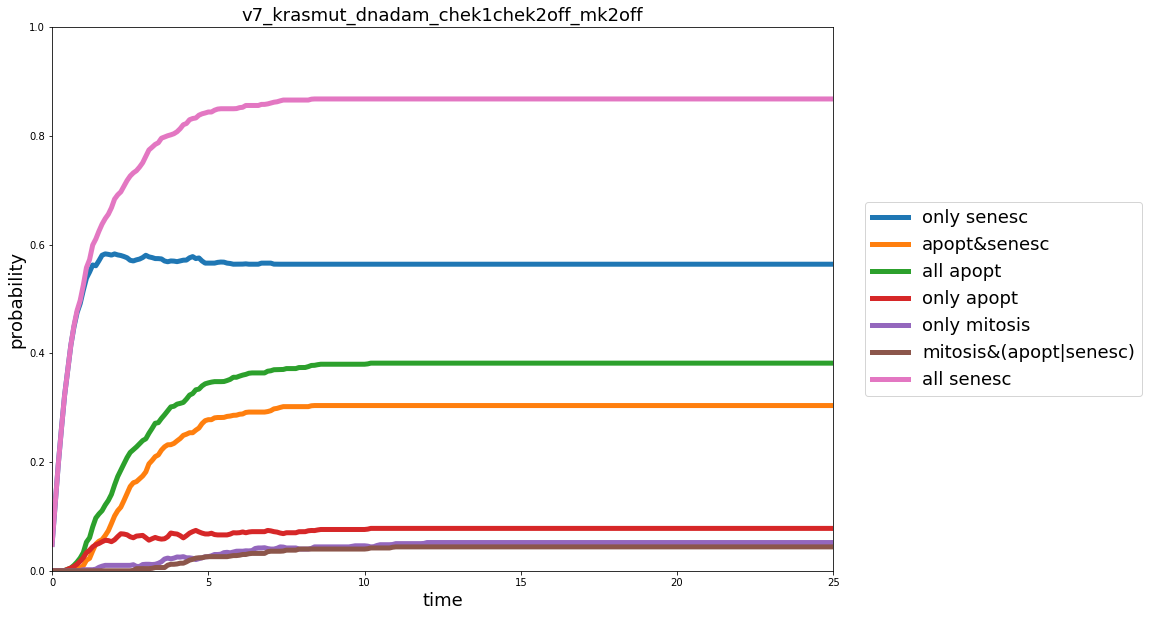

In [171]:
string_cellfates=["Apopt","Senesc","Mitos"]
cellfate_truthvals=fcn_truthval_states(states_probtraj_krasmut_dnadam_chek1chek2off_mk2off,string_cellfates)   
[apopt_cols,senesc_cols,mitosis_cols]=cellfate_truthvals

list_truthval=[~apopt_cols & senesc_cols,apopt_cols&senesc_cols,apopt_cols,apopt_cols&~senesc_cols,
           mitosis_cols&~apopt_cols&~senesc_cols,mitosis_cols&(apopt_cols|senesc_cols),senesc_cols]
list_labels=["only senesc","apopt&senesc","all apopt","only apopt",
             "only mitosis","mitosis&(apopt|senesc)","all senesc"]

str_plotname="_krasmut_dnadam_chek1chek2off_mk2off"; plot_pars=[14,10,18,5,1,25]
plot_cell_fates(states_probtraj_krasmut_dnadam_chek1chek2off_mk2off,model_name,str_plotname,plot_pars,
                list_truthval,list_labels,"")

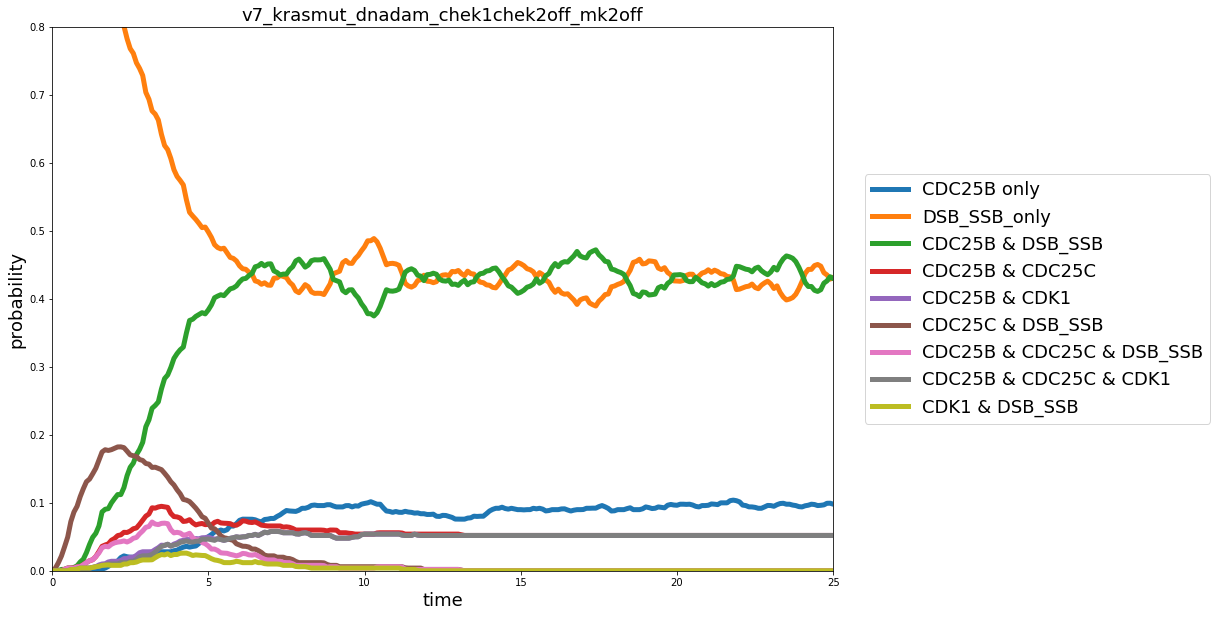

In [173]:
string_cellfates=["CDC25B","DSB_SSB","CDC25C","CDK1"]
truthval_states=fcn_truthval_states(states_probtraj_krasmut_dnadam_chek1chek2off_mk2off,string_cellfates)
[CDC25B_states,DSB_SSB_states,CDC25C_states,CDK1_states]=truthval_states

list_truthval=[CDC25B_states&~DSB_SSB_states,
               DSB_SSB_states&~CDC25B_states,
               CDC25B_states&DSB_SSB_states,
               CDC25B_states&CDC25C_states,
               CDC25B_states&CDK1_states,
               DSB_SSB_states&CDC25C_states,
              CDC25B_states&DSB_SSB_states&CDC25C_states,
              CDC25B_states&CDC25C_states&CDK1_states, CDK1_states&DSB_SSB_states]
list_labels=["CDC25B only","DSB_SSB_only", 
             "CDC25B & DSB_SSB","CDC25B & CDC25C",
             "CDC25B & CDK1","CDC25C & DSB_SSB",
             "CDC25B & CDC25C & DSB_SSB",
            "CDC25B & CDC25C & CDK1", "CDK1 & DSB_SSB"]

str_plotname="_krasmut_dnadam_chek1chek2off_mk2off"; plot_pars=[14,10,18,5,0.8,25]
plot_cell_fates(states_probtraj_krasmut_dnadam_chek1chek2off_mk2off,model_name,
                str_plotname,plot_pars,list_truthval,list_labels,"")

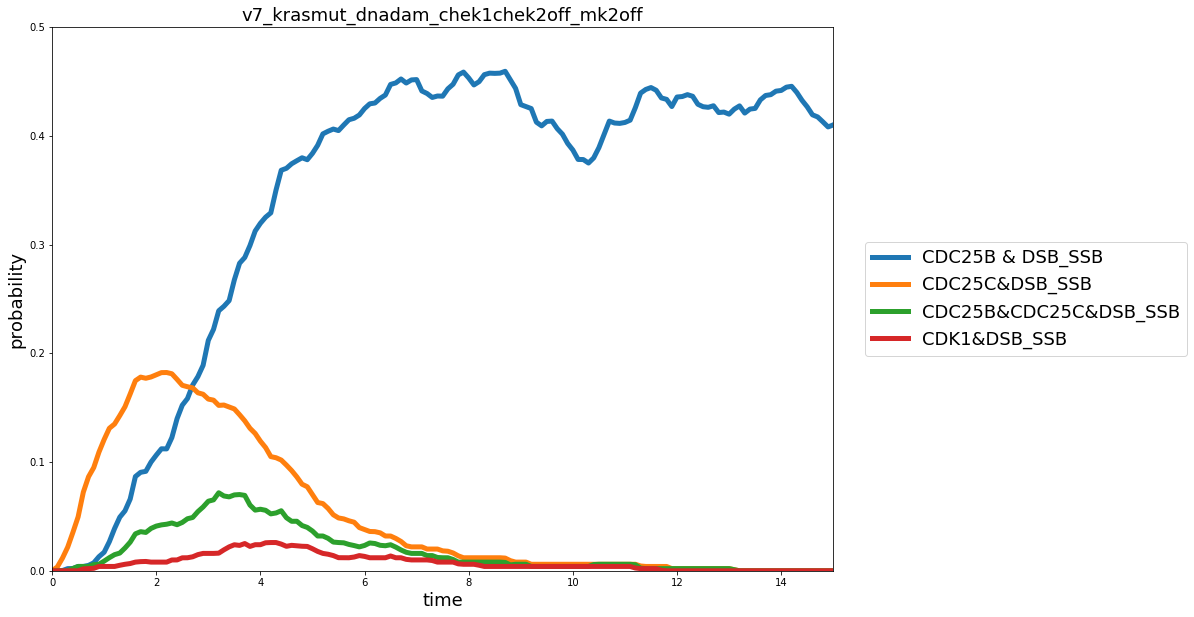

In [174]:
list_truthval=[CDC25B_states&DSB_SSB_states, CDC25C_states&DSB_SSB_states, CDC25B_states&CDC25C_states&DSB_SSB_states,
               CDK1_states&DSB_SSB_states]
list_labels=["CDC25B & DSB_SSB","CDC25C&DSB_SSB","CDC25B&CDC25C&DSB_SSB","CDK1&DSB_SSB"]
plot_pars=[14,10,18,5,0.5,15]
plot_cell_fates(states_probtraj_krasmut_dnadam_chek1chek2off_mk2off,model_name,
                str_plotname,plot_pars,list_truthval,list_labels,"")

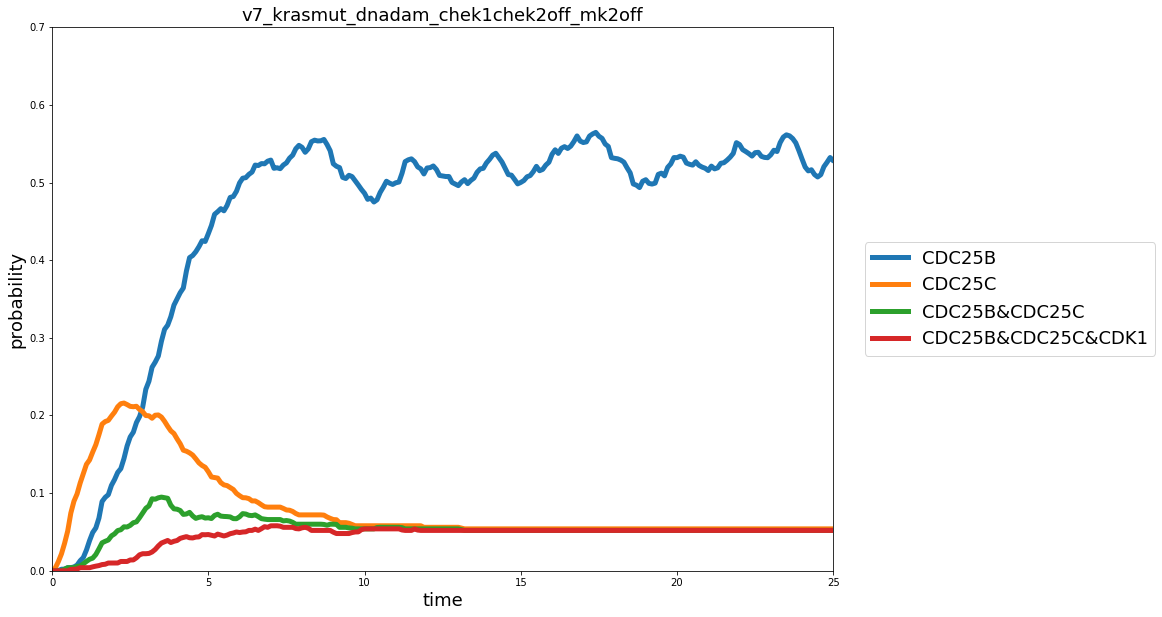

In [175]:
list_truthval=[CDC25B_states, CDC25C_states,CDC25B_states&CDC25C_states,CDC25B_states&CDC25C_states&CDK1_states]
list_labels=["CDC25B","CDC25C","CDC25B&CDC25C","CDC25B&CDC25C&CDK1"]
plot_pars=[14,10,18,5,0.7,25]
plot_cell_fates(states_probtraj_krasmut_dnadam_chek1chek2off_mk2off,model_name,
                str_plotname,plot_pars,list_truthval,list_labels,"")

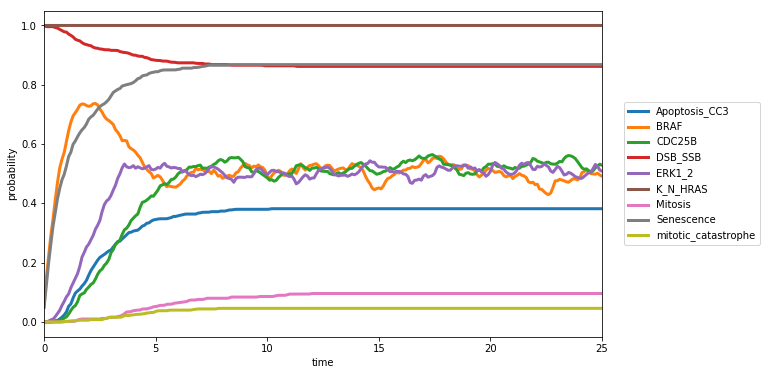

In [176]:
sel_vars=['RAS','BRAF','CHEK','MK2','mito','apopt','senesc','DSB','ERK','CDC25B'] # 'p38','ERK'
fig_pars=[3,10,6,"time","probability",25]
plot_node_dynamics(krasmut_dnadam_chek1chek2off_mk2off_results,sel_vars,fig_pars)

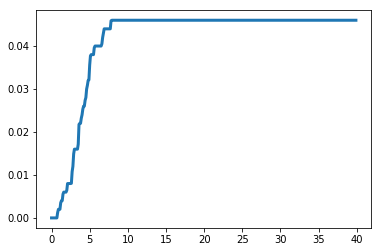

In [177]:
truthval=states_probtraj_krasmut_dnadam_chek1chek2off_mk2off.columns.str.contains("mitotic")
np.sum(states_probtraj_krasmut_dnadam_chek1chek2off_mk2off.loc[:,truthval],axis=1).plot(linewidth=3)

## All mutant results

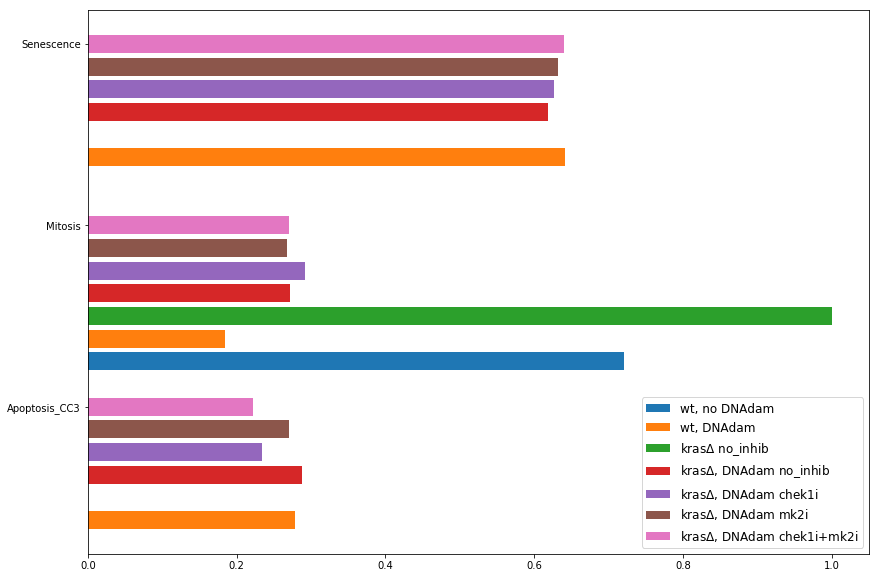

In [189]:
# plot the different mutants on subplots

# krasmut_nodnadam_results
kras_all_conds_lastnodes_prob=pd.concat([
           wt_nodnadam_results.get_last_nodes_probtraj(),
           master_results.get_last_nodes_probtraj(),
           krasmut_nodnadam_results.get_last_nodes_probtraj(),
           mutant_results.get_last_nodes_probtraj(), 
           krasmut_dnadam_chek1off_results.get_last_nodes_probtraj(), 
           krasmut_dnadam_mk2off_results.get_last_nodes_probtraj(), 
           krasmut_dnadam_chek1off_mk2off_results.get_last_nodes_probtraj()],ignore_index=True,sort=True)
barplot_titles=["wt, no DNAdam","wt, DNAdam","kras$\Delta$ no_inhib","kras$\Delta$, DNAdam no_inhib",
                "kras$\Delta$, DNAdam chek1i",
                "kras$\Delta$, DNAdam mk2i","kras$\Delta$, DNAdam chek1i+mk2i"]
sel_nodes=['Apoptosis_CC3','Senescence','Mitosis'] # ,'SSB','mit'
truthvals=kras_all_conds_lastnodes_prob.columns.str.contains(str.join("|",sel_nodes))

r1 = np.arange(np.sum(truthvals))*8

plt.figure(figsize=(plot_pars[0],plot_pars[1]));
for n in range(0,np.shape(kras_all_conds_lastnodes_prob)[0],1):
    last_nodes=kras_all_conds_lastnodes_prob.iloc[[n]].loc[:,truthvals]
    if n==(np.shape(kras_all_conds_lastnodes_prob)[0]-1):
        tick_label_str=last_nodes.columns
    else:
        tick_label_str=""
    plt.barh(r1+n*1,last_nodes.values[0],tick_label=tick_label_str)

fontsize_val=12
plt.legend(barplot_titles,bbox_to_anchor=(1.04,0.5),loc="center left",borderaxespad=0,fontsize=fontsize_val)
plt.legend(barplot_titles,loc="lower right",fontsize=12)
# plt.savefig("figures/"+model_name+"krasmut_dnadam_all.png",bbox_inches='tight')


In [201]:
p2x_addy=lambda x,y: x*x + y # (22,-33)
p2x_addy(22,-33)

451

In [202]:
high_ord_func = lambda x, func: x + func(x)
high_ord_func(13, lambda x: x*x)

182

In [ ]:
# export rules into boolnet
df_logical_rules=pd.DataFrame.from_dict(model.get_logical_rules(), orient='index')
df_logical_rules.reset_index(level=0, inplace=True); df_logical_rules.columns=['targets','factors']
df_logical_rules.to_csv('charitemodel_v5.bnet',index=False)

## Reachability: PINT
We need to impose constraints on reachable attractors.


In [ ]:
# PINT cannot read in Maboss or Boolnet models, so we need some intermediate format
# biolqm can export to 'booleannet', which PINT can import
# maboss -> biolqm -> pint
biolqm_model = maboss.to_biolqm(model)
biolqm.save(biolqm_model, "charitemodel_v5.booleannet", "booleannet")
model_pypint=pypint.load("charitemodel_v5.booleannet")
# mutation -> reachability
init_state=model.get_initial_state()
model_pypint.initial_state['TP53']=[0,1]
# transfer the initial states from the MaBoSS model
# maboss.widgets.wg_transfer_istate(model.network, model_pypint)
# set (some) output nodes to 0
import itertools
all_init_nodes=list(itertools.chain.from_iterable([nodes_init_off,nodes_init_on]))
for nd in all_init_nodes:
    if nd in nodes_init_off:
        model_pypint.initial_state[nd]=[1,0]
    elif nd in nodes_init_on:
        model_pypint.initial_state[nd]=[0,1]

In [ ]:
# model's features
import networkx as nx
model_pypint.summary()
# model_pypint.automata
np.shape(model_pypint.local_transitions)
# VISUALIZE
pkn_plot=model_pypint.dependency_graph() 
# plt.figure(1,figsize=(12,12)) 
# nx.draw(pkn_plot,nx.spring_layout(pkn_plot),with_labels=True,node_size=3000,font_size=12)
# plt.savefig("netwokx_plot.png",format="PNG")

In [ ]:
from pypint import Goal # avoid typing pypint

# Data

## WES and FACS

In [101]:
# ~/research/models/KRAS_DNA_repair_model/data/wes_facs/wes_facs_data_tidy.csv
# ~/research/models/KRAS_DNA_repair_model/pymaboss/charitemodel_notes.ipynb
wes_facs_data_tidy=pd.read_csv("../data/wes_facs/wes_facs_data_tidy_scaled_vals.csv")
wes_facs_data_tidy.head()

,chek1i,mk2i,etoposide,treatment,cell_line,expertype,time,variable,value,log2_scaled_value,scaled_value,scaled_value_no_etop,scaled_value_no_etop_across_samples,trunc_variable
0,0.0,0.0,0,DMSO,HCT116,wes,NaN,pChk1_S296,1.000,0.571,0.233,1.000,0.373,pChk1
1,0.5,0.0,0,0.5µM Chk1i,HCT116,wes,NaN,pChk1_S296,0.607,0.408,0.122,0.524,0.219,pChk1
2,1.0,0.0,0,1µM Chk1i,HCT116,wes,NaN,pChk1_S296,0.420,0.288,0.069,0.298,0.146,pChk1
3,0.0,2.5,0,2.5µM Mk2i,HCT116,wes,NaN,pChk1_S296,0.939,0.550,0.215,0.926,0.349,pChk1
4,0.5,2.5,0,0.5µM Chk1i/ 2.5µM Mk2i,HCT116,wes,NaN,pChk1_S296,0.288,0.164,0.032,0.138,0.094,pChk1


## Viability

## Solve ODE by SciPy

In [81]:
from scipy.integrate import ode
from scipy.integrate import odeint

In [ ]:
# example ODE

# def f1_ode(t,u):
#     return [u[1],3*(1-u[0]*u[0])*u[1]-u[0]]

# # create ODE object
# # r = ode(f1_ode).set_integrator('vode',method='adams',order=10,rtol=0,atol=1e-6,with_jacobian=False)
# ode_object=ode(f1_ode).set_integrator('lsoda',method='adams',rtol=0,atol=1e-6,with_jacobian=False)
# # set initial condition, timespan
# u0=[2,0]; ode_object.set_initial_value(u0,0); Tmax=30; n_timestep=150
# # fcn solve ode
# time,sols=solve_ode(ode_object,Tmax,n_timestep,u0)

# # within solve_ode
# #
# # while r.successful() and r.t <= T:
# #    r.integrate(r.t + dt)
# #    u.append(r.y);  t.append(r.t)

# # PLOT
# lineObjects=plt.plot(time,sols)
# plt.legend(lineObjects,('u(1)','u(2)')); plt.xlabel('time'); plt.ylabel('u(t)')
# fig_nodetraj=plt.gcf(); fig_nodetraj.set_size_inches(10,5)
# plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0)

#####
# 2nd example
#
# fcn for ODE
# def pend(y, t, b, c):
#     theta, omega = y
#     dydt = [omega, -b*omega - c*np.sin(theta)]
#     return dydt
# # params
# b=0.25;c=5; y0=[np.pi-0.1,0]; t=np.linspace(0, 10, 101)
# # solve
# sol=odeint(pend, y0, t, args=(b, c))
# plt.plot(t,sol)

In [ ]:
# testing algebr approx. of sign/heaviside fcns:

# fcn_sgn_eps_approx
# fcn_sgn_hvs_eps_approx
# fcn_or_operator_fcns

# fcn_sgn_eps_approx([1,2,3],1e-4)
# numpy.array([3,4,5])
nvals=np.array([-11,-1,-0.1, 0, 6]); epsilon=1e-4
# nvals/np.sqrt(np.square(nvals) + epsilon**2)
np.round(fcn_sgn_eps_approx(nvals,epsilon),4)
np.round(fcn_sgn_hvs_eps_approx(nvals,epsilon),4)
np.round(fcn_or_operator_fcns(nvals,nvals,epsilon),4)

In [251]:
# solve cellfate ODE
params=[1,1,1.9,1e-4,0,1]; ko_flag=[];
x0=[0.5,0.5,0,0,0,0]; tmax=15; t=np.linspace(0,tmax,tmax*10+1)
sol_cellfate=odeint(f_cellfate_ode,x0,t,args=(params,ko_flag))
node_names=['kras','dnadam','dnarep','chek1','mitosis','celldeath']

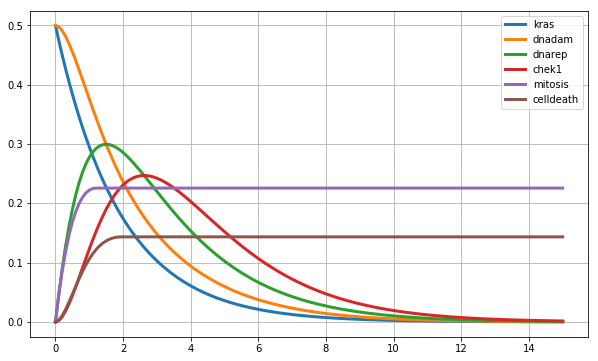

In [202]:
lineObjects=plt.plot(t,sol_cellfate,label=node_names,linewidth=3); plt.legend(lineObjects,node_names)
fig_nodetraj=plt.gcf(); fig_nodetraj.set_size_inches(10,6); plt.grid()

In [174]:
np.round(sol_cellfate[150,:],3)

array([0.   , 0.   , 0.001, 0.002, 0.226, 0.144])

In [198]:
# set up equivalent maboss model
# from maboss import Node, Network
# from maboss import Simulation

cellfate_model = maboss.load("tutorial/cellfate_6nodes.bnd")
# define initial states
cellfate_model.network.set_istate(['kras','dnadam','dnarep','chek1','mitosis','celldeath'],
                          {(0,1,0,0,0,0):1/2,(1,0,0,0,0,0):1/2})

maboss.set_output(cellfate_model,node_names)
cellfate_model.update_parameters(discrete_time=0, use_physrandgen=0,
                            seed_pseudorandom=100, sample_count=10000,
                            max_time=15, time_tick=0.1, thread_count=4,
                            statdist_traj_count=100, statdist_cluster_threshold=0.9)

cellfate_model_results = cellfate_model.run()

# byHand_sim_result = byHand_sim.run()
# byHand_sim_result.get_nodes_probtraj()

In [199]:
cellfate_model_results.get_last_nodes_probtraj()

,celldeath,dnarep,mitosis
14.8000,0.1066,0.0001,0.2253


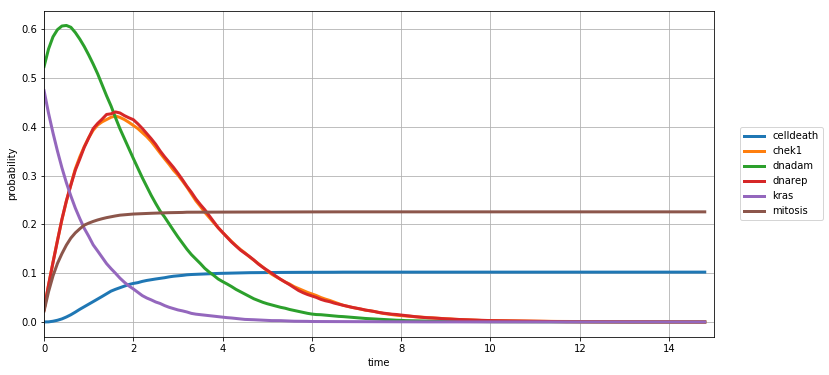

In [192]:
# cellfate_model_results.plot_node_trajectory()
fig_pars=[3,12,6,"time","probability",15]; nodes_string=node_names
plot_node_dynamics(cellfate_model_results,nodes_string,fig_pars);  plt.grid()